# Notebook to prepare data for analysis

In [1]:
import json

import matplotlib
import pandas
import shapely.geometry

%matplotlib inline

## Prep materials

In [2]:
listings_all = pandas.read_csv('listings.csv')

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


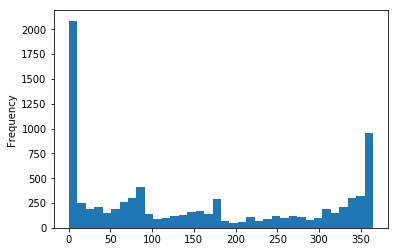

In [3]:
listings_all['availability_365'].plot.hist(bins=36)

In [4]:
listings = listings_all #listings_all[listings_all['availability_365'] >= 30].copy()

In [5]:
with open('zoning.geojson') as f:
    zoning_raw = json.load(f)

In [55]:
with open('zoning_simplifications.json') as f:
    zoning_simplifications = json.load(f)

In [7]:
zoning_raw['features'][0]

{'type': 'Feature',
 'properties': {'zoning_sim': 'NC-1',
  'commercial_hours_of_operation': '6:00AM-11:00PM',
  'shape_area': '2.3987989208947789E-7',
  'url': 'http://library.amlegal.com/nxt/gateway.dll/California/planning/article7neighborhoodcommercialdistricts?f=templates$fn=default.htm$3.0$vid=amlegal:sanfrancisco_ca$anc=JD_710.1',
  'districtname': 'NEIGHBORHOOD COMMERCIAL, CLUSTER',
  'zoning': 'NC-1',
  'codesection': '710.1',
  'objectid': '19770',
  'shape_length': '0.0026884456653202106',
  'gen': 'Mixed Use'},
 'geometry': {'type': 'MultiPolygon',
  'coordinates': [[[[-122.428306959, 37.743600279],
     [-122.428882686, 37.743565342],
     [-122.429249081, 37.743543105],
     [-122.429250169, 37.743554407],
     [-122.429257392, 37.743629451],
     [-122.429264535, 37.743703672],
     [-122.429040378, 37.743717196],
     [-122.428898126, 37.743725778],
     [-122.428911143, 37.743861043],
     [-122.42879804, 37.743867866],
     [-122.42876889, 37.743869624],
     [-122.428

In [8]:
zone_geometries = []

In [9]:
for feature in zoning_raw['features']:
    properties = feature['properties']
    zone_geometries.append({
        'name': properties['districtname'],
        'zoning': properties['zoning'],
        'geometry': shapely.geometry.shape(feature['geometry'])
    })

## Join

In [10]:
len(zone_geometries)

1648

**Prep Points**

In [11]:
listings.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,958,https://www.airbnb.com/rooms/958,20191204162709,2019-12-04,"Bright, Modern Garden Unit - 1BR/1B",New update: the house next door is under const...,"Newly remodeled, modern, and bright garden uni...",New update: the house next door is under const...,none,*Quiet cul de sac in friendly neighborhood *St...,...,f,f,moderate,f,f,1,1,0,0,1.79
1,3850,https://www.airbnb.com/rooms/3850,20191204162709,2019-12-04,Charming room for two,Your own private room plus access to a shared ...,This room can fit two people. Nobody else will...,Your own private room plus access to a shared ...,none,"This is a quiet, safe neighborhood on a substa...",...,f,f,strict_14_with_grace_period,f,f,3,0,3,0,1.38
2,5858,https://www.airbnb.com/rooms/5858,20191204162709,2019-12-05,Creative Sanctuary,NaN,We live in a large Victorian house on a quiet ...,We live in a large Victorian house on a quiet ...,none,I love how our neighborhood feels quiet but is...,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.86
3,7918,https://www.airbnb.com/rooms/7918,20191204162709,2019-12-04,A Friendly Room - UCSF/USF - San Francisco,Nice and good public transportation. 7 minute...,"Settle down, S.F. resident, student, hospital,...",Nice and good public transportation. 7 minute...,none,"Shopping old town, restaurants, McDonald, Whol...",...,f,f,strict_14_with_grace_period,f,f,9,0,9,0,0.14
4,8142,https://www.airbnb.com/rooms/8142,20191204162709,2019-12-04,Friendly Room Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,"Settle down, S.F. resident, student, hospital,...",Nice and good public transportation. 7 minute...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,9,0,9,0,0.13


In [12]:
listings['point'] = listings.apply(lambda x: shapely.geometry.Point(x['longitude'], x['latitude']), axis=1)

**Prep Lookup**

In [13]:
def lookup_zone(point):
    results = list(filter(lambda x: x['geometry'].contains(point), zone_geometries))
    if len(results) == 0:
        return [{'name': 'Unknown', 'zoning': 'unknown'}]
    else:
        return results

**Test Lookup**

In [14]:
sample = listings.iloc[100]

In [15]:
lookup_zone(sample['point'])

[{'name': 'RESIDENTIAL- HOUSE, ONE FAMILY',
  'zoning': 'RH-1',
  'geometry': <shapely.geometry.multipolygon.MultiPolygon at 0x11d4c30b8>}]

**Execute**

In [16]:
def lookup_zone_str_with_error_handle(point):
    try:
        return lookup_zone(point)
    except:
        return [{'name': 'Error', 'zoning': 'error'}]

In [17]:
listings['zoningDetailed'] = listings['point'].map(lambda x: lookup_zone_str_with_error_handle(x))

In [39]:
def serialize_zoning_detailed(original_list):
    new_list = list(map(lambda x: {'name': x['name'], 'zoning': x['zoning']}, original_list))
    return json.dumps(new_list)

In [40]:
listings['zoning'] = listings['zoningDetailed'].map(lambda x: x[0]['zoning'])
listings['numZones'] = listings['zoningDetailed'].map(lambda x: len(x))
listings['zoningDetailedJson'] = listings['zoningDetailed'].map(serialize_zoning_detailed)

## Cleanup

**Siplify Zones**

In [56]:
zone_counts = listings.groupby('zoning').count()['id']

In [57]:
zone_counts.sort_values(ascending=False).head(10)

zoning
RH-2       1522
RH-1       1230
RH-3        892
P           621
RM-1        479
RC-4        419
C-3-G       357
RH-1(D)     244
RTO         193
RM-3        183
Name: id, dtype: int64

In [58]:
listings['zoningSimplified'] = listings['zoning'].map(lambda x: zoning_simplifications.get(x, 'unknown'))

In [59]:
zone_counts_simplified = listings.groupby('zoningSimplified').count()['id']

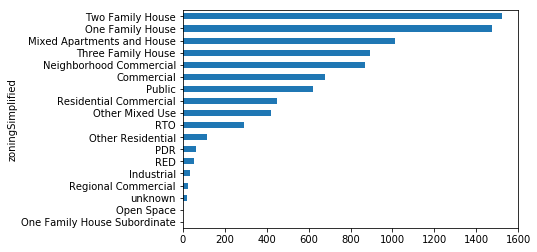

In [60]:
zone_counts_simplified.sort_values(ascending=True).plot.barh()

In [61]:
zone_counts_simplified.sort_values(ascending=False).to_csv('sorted_counts.csv')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


## Export

In [62]:
with open('col_mapping.json') as f:
    col_mapping = json.load(f)

In [63]:
listings.rename(columns=col_mapping).to_csv('listings_with_zone.csv')